# Producing pseudo-`tree.TRW` using VS-Lite

In this section, we illustrate how to generate pseudoproxies for `tree.TRW` using VS-Lite with `cfr`.

Required data to complete this tutorial:

- The PAGES2k database: [pages2k_dataset.nc](./data/pages2k_dataset.nc)
- CRU TS 4.05 tmp & pre: [homepage on CEDA](https://catalogue.ceda.ac.uk/uuid/c26a65020a5e4b80b20018f148556681)
- iCESM simulated air surface temperature: [tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc)
- iCESM simulated precipitation rate: [pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import cfr
import numpy as np
import xarray as xr

In [7]:
from matplotlib import font_manager

font_dirs = ['/glade/u/home/fengzhu/.fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

os.chdir('/glade/u/home/fengzhu/Github/cfr/docsrc/notebooks')
!pwd

/glade/u/home/fengzhu/Github/cfr/docsrc/notebooks


## Load the PAGES2k database and access a target record

In [ ]:
df = pd.read_pickle('./data/pages2k_dataset.pkl')
pdb = cfr.ProxyDatabase().from_df(df)
pobj = pdb['NAm_136']
fig, ax = pobj.plot()

## Load the model simulated tas & pr

Note that we need to load the absolute values instead of anomalies as per VS-Lite's input requirement.

In [4]:
dirpath = './data/'
# dirpath = './data/MBC'

model_tas = cfr.ClimateField().load_nc(
    os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
    # os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512_dOTC.nc'))

model_pr = cfr.ClimateField().load_nc(
    os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
    # os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512_dOTC.nc'))

## Load the instrumental observations

Note that we need to load the absolute values instead of anomalies as per VS-Lite's input requirement.

In [5]:
dirpath = './data/CRUTS'

obs_tas = cfr.ClimateField().load_nc(
    os.path.join(dirpath, 'cru_ts4.05.1901.2020.tmp.dat.nc'),
    vn='tmp').rename('tas')

obs_pr = cfr.ClimateField().load_nc(
    os.path.join(dirpath, 'cru_ts4.05.1901.2020.pre.dat.nc'),
    vn='pre').rename('pr')

In [6]:
obs_tas.da

<xarray.DataArray 'tas' (time: 1440, lat: 360, lon: 720)>
[373248000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

For the usage with `cfr`, we need to wrap the longitude from the range [-180, 180] to [0, 360]:

In [7]:
obs_tas = obs_tas.wrap_lon()
obs_pr = obs_pr.wrap_lon()

In [8]:
obs_tas.da

<xarray.DataArray 'tas' (time: 1440, lat: 360, lon: 720)>
[373248000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Get the model simulated and instrumental climate data

In [9]:
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas, tag='obs')
pobj.get_clim(obs_pr, tag='obs')

## Get the model gridcell elevation data and bias correct the model simulated tas

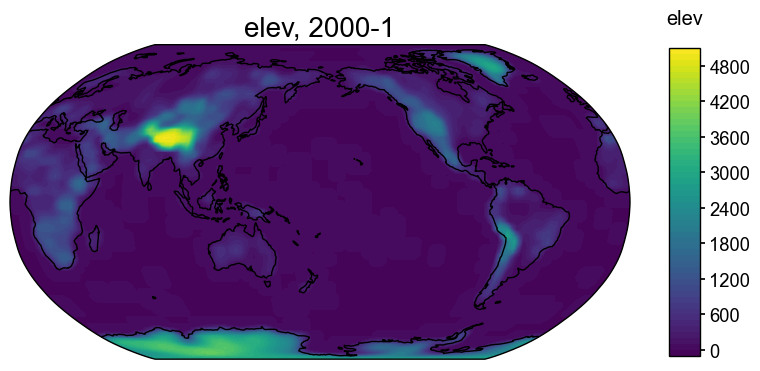

In [10]:
ds = xr.open_dataset('./data/consistent-topo-fv1.9x2.5_c130424.nc')
elev = ds['PHIS']/9.806
elev_fd = cfr.ClimateField().from_da(elev.rename('elev'))
fig, ax = elev_fd.plot()

In [11]:
pobj.get_clim(elev_fd, tag='model')
pobj.clim['model.elev'].da

<xarray.DataArray 'elev' (time: 1)>
array([1309.53966278])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01
    lat      float64 50.21
    lon      float64 242.5

In [12]:
pobj.correct_elev_tas(verbose=True)

tas correction due to elevation difference (proxy - model): 520.46 meters.
NAm_136 >>> ProxyRecord.clim["model.tas"] corrected by: -5.10 degC.


## Calibrate and run the `VSLite` PSM

In [11]:
pobj.get_pseudo(
    cfr.psm.VSLite,    # the PSM
    match_mean=True,   # match mean of the real record over the common timespan
    match_var=True,    # match variance of the real record over the common timespan
    forward_kws={'I_0': -4},
)


    _pyeval at line 57 column 30




Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0002   1.0038   0.9999   0.9998   1.0637
(12, 1156)


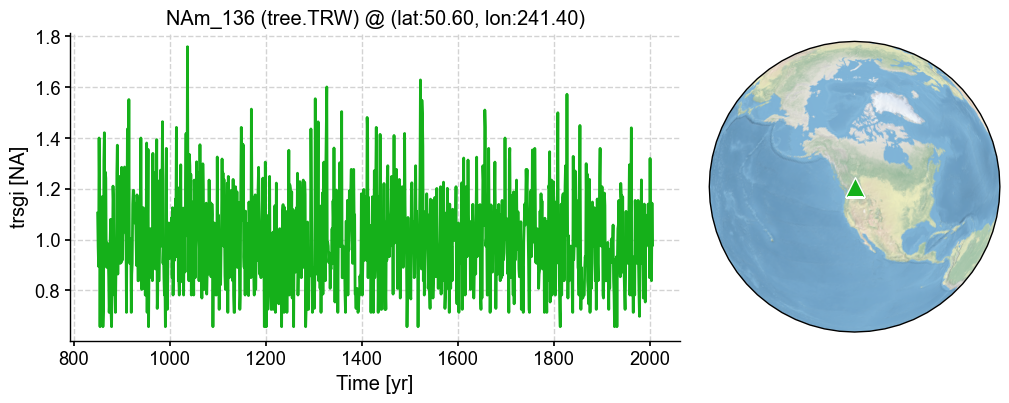

In [12]:
fig, ax = pobj.pseudo.plot()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


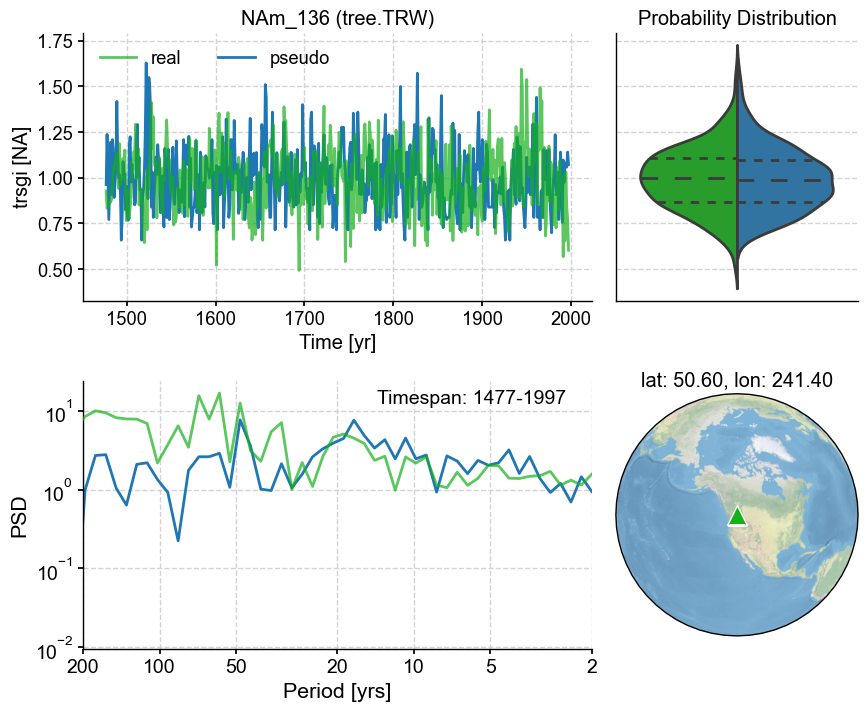

In [13]:
# specify a timespan
min_t = np.max([850, np.min(pobj.time)])
max_t = np.min([2000, np.max(pobj.time)])
timespan = (min_t, max_t)

# annualize the proxy series
pobj_ann = pobj.slice(timespan).annualize()

# bind the pseudoproxy counterpart
pobj_ann.pseudo = pobj.pseudo.slice(timespan)

# plot the dashboard
fig, ax = pobj_ann.dashboard()

In [13]:
pobj.get_pseudo(
    cfr.psm.VSLite,    # the PSM
    match_mean=True,   # match mean of the real record over the common timespan
    match_var=True,    # match variance of the real record over the common timespan
)


    _pyeval at line 57 column 30




Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0046   1.0009   1.0028   0.9993   1.0681


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


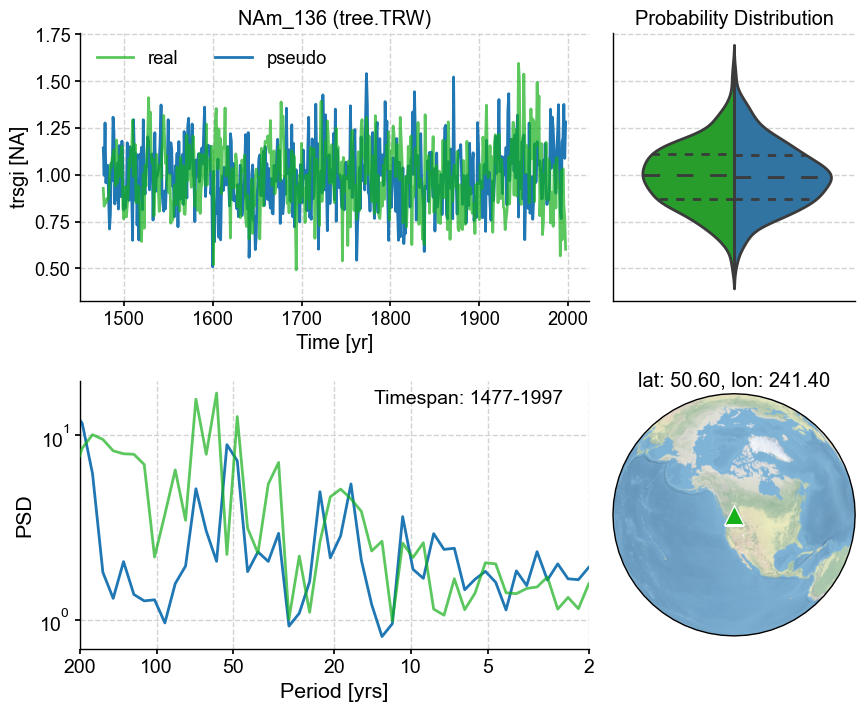

In [14]:
# specify a timespan
min_t = np.max([850, np.min(pobj.time)])
max_t = np.min([2000, np.max(pobj.time)])
timespan = (min_t, max_t)

# annualize the proxy series
pobj_ann = pobj.slice(timespan).annualize()

# bind the pseudoproxy counterpart
pobj_ann.pseudo = pobj.pseudo.slice(timespan)

# plot the dashboard
fig, ax = pobj_ann.dashboard()